In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'

100% 7.24G/7.25G [01:22<00:00, 106MB/s]
100% 7.25G/7.25G [01:22<00:00, 93.9MB/s]


In [3]:
!mkdir dr
! unzip diabetic-retinopathy-resized.zip -d dr

Streaming output truncated to the last 5000 lines.
  inflating: dr/resized_train_cropped/resized_train_cropped/44260_right.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44265_right.jpeg  
  inflating: dr/resized_train_cropped/resized_train_cropped/44267_left.jpeg  
  infla

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.metrics import AUC,Precision,Recall
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout,Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.metrics import AUC,Precision,Recall
from sklearn.model_selection import KFold
import math
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import shutil
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,\
    Dropout, Dense, Input, concatenate, ZeroPadding2D,  \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, add, Activation, Flatten,GlobalMaxPool2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall, FalseNegatives, FalsePositives,TrueNegatives,TruePositives, CategoricalCrossentropy
from tensorflow.keras.models import load_model
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from sklearn.model_selection import KFold
#from scikitplot.metrics import plot_confusion_matrix, plot_roc
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPool2D, Concatenate
import math  
import matplotlib.pyplot as plt
import os

import numpy as np

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
data = pd.read_csv("/content/dr/trainLabels.csv",dtype=str)
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [7]:
data['image_name'] = [i+".jpeg" for i in data['image'].values]
data.head()

,image,level,image_name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

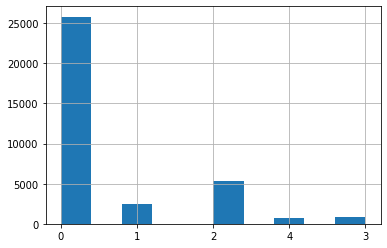

In [8]:
data['level'].hist()
data['level'].value_counts()

In [9]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size=0.4)
from keras.preprocessing.image import ImageDataGenerator
import cv2
def load_ben_color(image):
    IMG_SIZE = 224
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

In [10]:
data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.15,
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=load_ben_color)

In [11]:
bs = 32

train_gen = data_gen.flow_from_dataframe(train, 
                                         "/content/dr/resized_train/resized_train/",
                                         x_col="image_name", y_col="level", class_mode="categorical",
                                         batch_size=bs,
                                         target_size=(224, 224))
val_gen = data_gen.flow_from_dataframe(val,
                                       "/content/dr/resized_train/resized_train/",
                                       x_col="image_name", y_col="level", class_mode="categorical",
                                       batch_size=bs,
                                       target_size=(224, 224))

Found 21075 validated image filenames belonging to 5 classes.
Found 14051 validated image filenames belonging to 5 classes.


In [12]:
from keras.applications.vgg16 import VGG16
import keras.layers as L
from keras.models import Model

In [13]:
model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [14]:
'''for layer in model.layers[:12]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)'''

'for layer in model.layers[:12]:\n    layer.trainable = False\n# Make sure you have frozen the correct layers\nfor i, layer in enumerate(model.layers):\n    print(i, layer.name, layer.trainable)'

In [15]:
x = Flatten()(model.output)
x=Dense(units=1024)(x)
x=Dense(units=64,activation='relu')(x)
output = Dense(units=5, activation="softmax")(x)
model = Model(inputs = model.input, outputs = output)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 40,471,749
Trainable params: 40,471,749
Non-trainable params: 0
_________________________________________________________________


In [17]:
'''def residual_module(layer_in, n_filters,seq_strides=2,short_cut_stride=2):
    merge_input = layer_in
    x = Conv2D(n_filters, (1,1), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(layer_in)
    x = BatchNormalization(axis=3)(x)
    x = Activation('linear')(x)
    reduction_ratio=16
    avgpool = GlobalAveragePooling2D()(x)
    maxpool = GlobalMaxPool2D()(x)
    # Shared MLP
    Dense_layer1 = Dense(n_filters//reduction_ratio, activation='relu')
    Dense_layer2 = Dense(n_filters, activation='relu')
    avg_out = Dense_layer2(Dense_layer1(avgpool))
    max_out = Dense_layer2(Dense_layer1(maxpool))
    channel = layers.add([avg_out, max_out])
    channel = Activation('sigmoid')(channel)
    channel = Reshape((1,1,n_filters))(channel)
    channel_out = tf.multiply(x, channel)
    avgpool = tf.reduce_mean(channel_out, axis=3, keepdims=True)
    maxpool = tf.reduce_max(channel_out, axis=3, keepdims=True)
    spatial = Concatenate(axis=3)([avgpool, maxpool])
    spatial = Conv2D(1, (7,7), strides=1, padding='same')(spatial)
    spatial_out = Activation('sigmoid')(spatial)
    CBAM_out = tf.multiply(channel_out, spatial_out)
    x = Conv2D(n_filters, (3,3), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(layer_in)
    x = layers.add([CBAM_out, x])
    # activation function
    layer_out = Activation('relu')(x)
    return layer_out

input_layer = Input(shape=(256,256,3))
x = residual_module(input_layer,128)
x = residual_module(x,16)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,16)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,32)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,32)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,64)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,64)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)
x = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2())(x)
output = Dense(5,activation='sigmoid')(x)
model = Model(inputs=input_layer,outputs=output)
model.summary()'''

"def residual_module(layer_in, n_filters,seq_strides=2,short_cut_stride=2):\n    merge_input = layer_in\n    x = Conv2D(n_filters, (1,1), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(layer_in)\n    x = BatchNormalization(axis=3)(x)\n    x = Activation('linear')(x)\n    reduction_ratio=16\n    avgpool = GlobalAveragePooling2D()(x)\n    maxpool = GlobalMaxPool2D()(x)\n    # Shared MLP\n    Dense_layer1 = Dense(n_filters//reduction_ratio, activation='relu')\n    Dense_layer2 = Dense(n_filters, activation='relu')\n    avg_out = Dense_layer2(Dense_layer1(avgpool))\n    max_out = Dense_layer2(Dense_layer1(maxpool))\n    channel = layers.add([avg_out, max_out])\n    channel = Activation('sigmoid')(channel)\n    channel = Reshape((1,1,n_filters))(channel)\n    channel_out = tf.multiply(x, channel)\n    avgpool = tf.reduce_mean(channel_out, axis=3, keepdims=True)\n    maxpool = tf.reduce_max(channel_out, axis=3, keepdims=True)\n    spatial = Conca

In [18]:
initial_lrate = 0.00008
def decay(epoch, steps=10):
    initial_lrate = 0.000008
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
opt = Adam(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',AUC(),Precision(),Recall(),FalsePositives(),TrueNegatives(),TruePositives(),FalseNegatives()])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:

checkpoint = ModelCheckpoint("with_chmod_100_spatial.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, mode='auto',patience=25)
callback = [checkpoint,early]

In [20]:
hist = model.fit(train_gen, validation_data=val_gen ,batch_size=bs, epochs=30,callbacks=callback)

Epoch 1/30
659/659 [==============================] - 785s 1s/step - loss: 0.9241 - accuracy: 0.7258 - auc: 0.8633 - precision: 0.7228 - recall: 0.7057 - false_positives: 1415.3129 - true_negatives: 19797.9072 - true_positives: 3860.9915 - false_negatives: 1442.3129 - val_loss: 0.8545 - val_accuracy: 0.7358 - val_auc: 0.8893 - val_precision: 0.7350 - val_recall: 0.7343 - val_false_positives: 7448.1387 - val_true_negatives: 105075.5625 - val_true_positives: 20655.7949 - val_false_negatives: 7475.1387

Epoch 00001: val_accuracy improved from -inf to 0.73582, saving model to with_chmod_100_spatial.h5
Epoch 2/30
659/659 [==============================] - 717s 1s/step - loss: 0.8534 - accuracy: 0.7316 - auc: 0.8922 - precision: 0.7348 - recall: 0.7328 - false_positives: 10684.5193 - true_negatives: 151018.9831 - true_positives: 29617.3593 - false_negatives: 10808.5054 - val_loss: 0.7657 - val_accuracy: 0.7462 - val_auc: 0.9012 - val_precision: 0.7458 - val_recall: 0.7251 - val_false_positiv

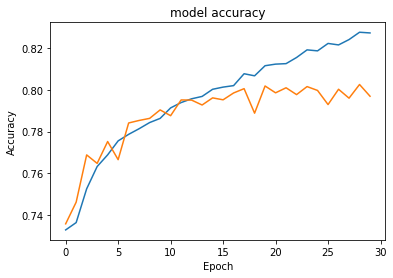

In [23]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

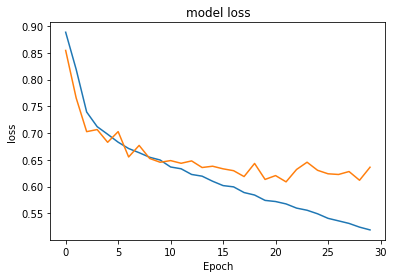

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.show()

In [26]:
model.load_weights('with_chmod_100_spatial.h5')

In [27]:
model_metrics = model.evaluate(val_gen,verbose=0)

In [28]:
f1_score = 2*( (model_metrics[3]*model_metrics[4]) / (model_metrics[3]+model_metrics[4]) )

In [29]:
print(f"Accuracy on test set: {round(model_metrics[1]*100,2)}%")
print(f"ROC(Receiver Operation Characteristic) AUC(Area Under Curve): {model_metrics[2]}")
print(f"Precision: {round(model_metrics[3]*100,2)}%")
print(f"Recall: {round(model_metrics[4]*100,2)}%")
print(f"F1-score: {f1_score}")
print(f"Specificity: {(model_metrics[6])/(model_metrics[6]+model_metrics[5])}")

Accuracy on test set: 79.69%
ROC(Receiver Operation Characteristic) AUC(Area Under Curve): 0.9441032409667969
Precision: 81.36%
Recall: 76.73%
F1-score: 0.789766860657463
Specificity: 0.9560452460410863
